In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Choose the experiment file source:

In [11]:
experiment = "manual_vs_auto.xlsx"
df = pd.read_excel(experiment)

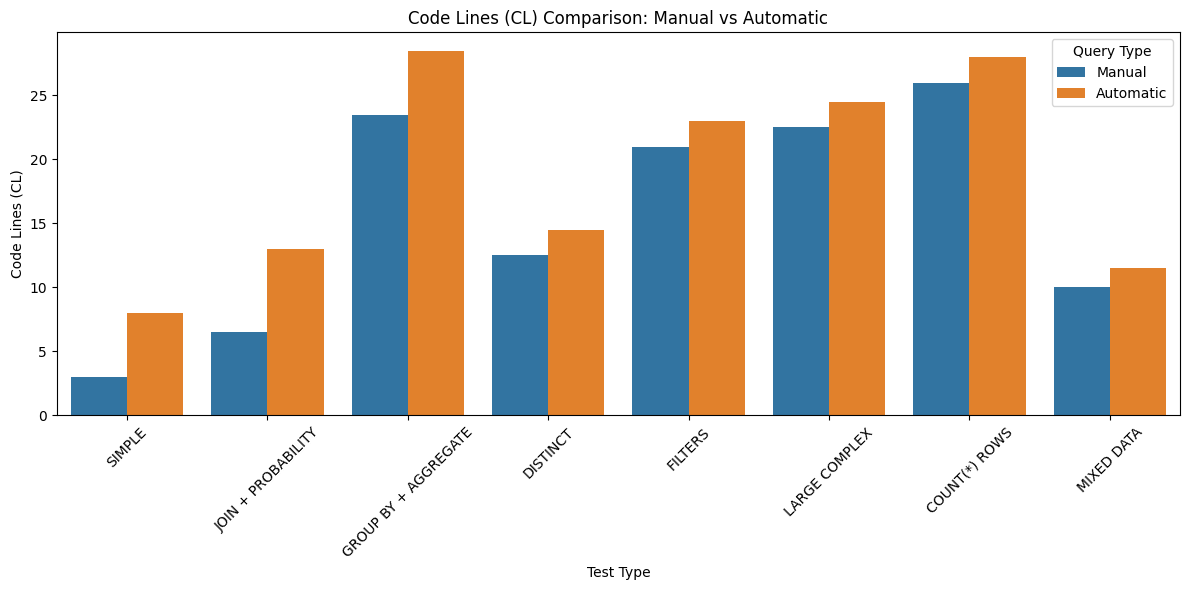

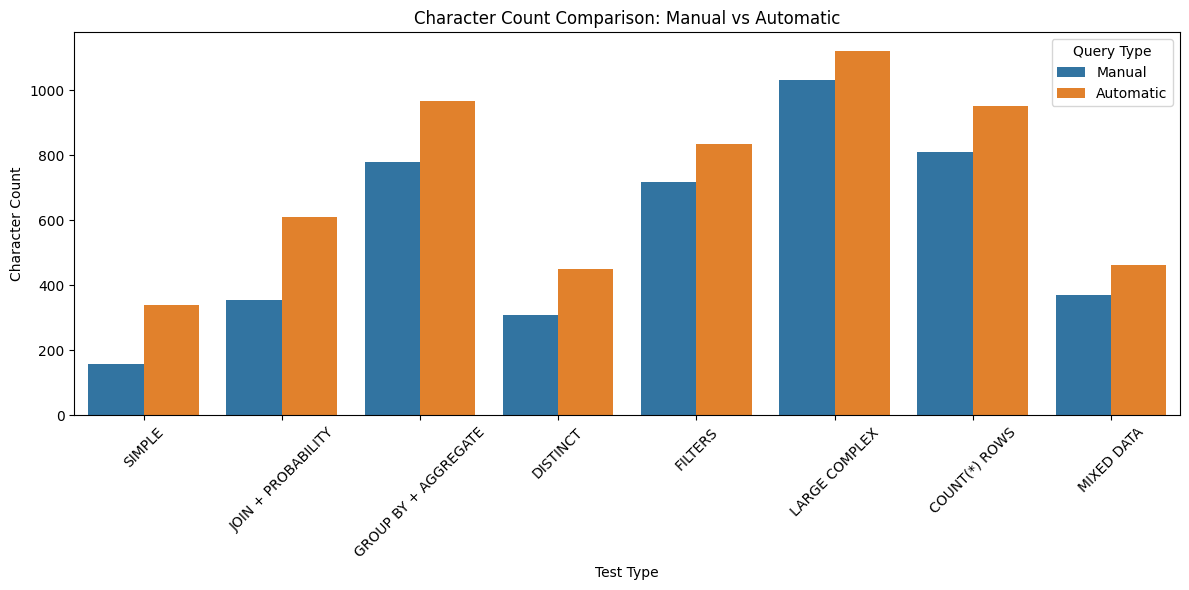

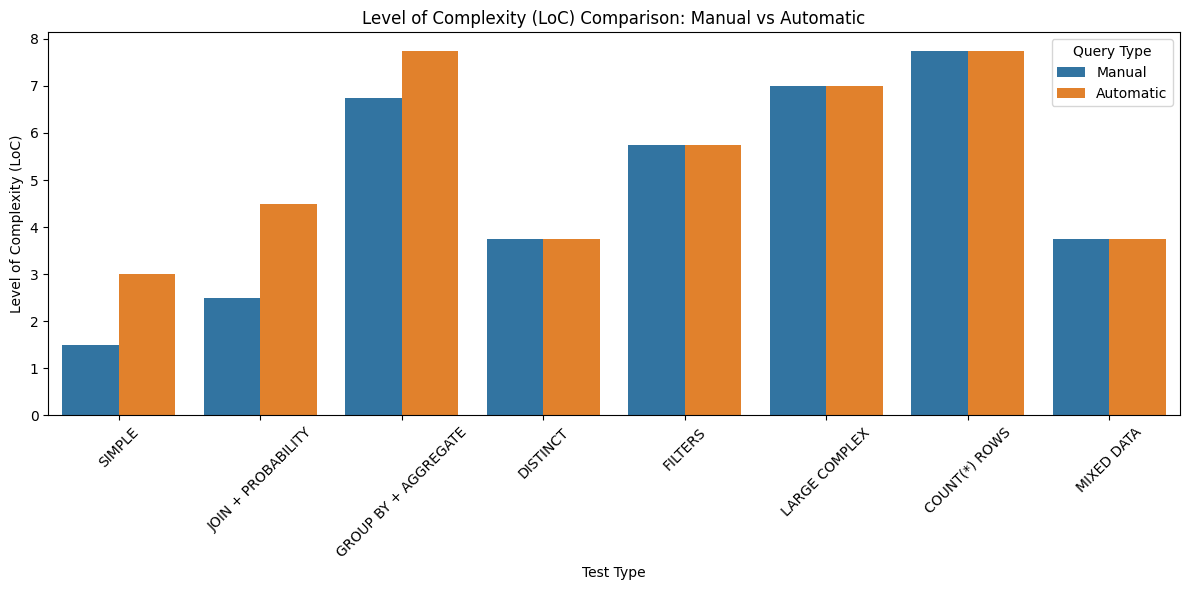

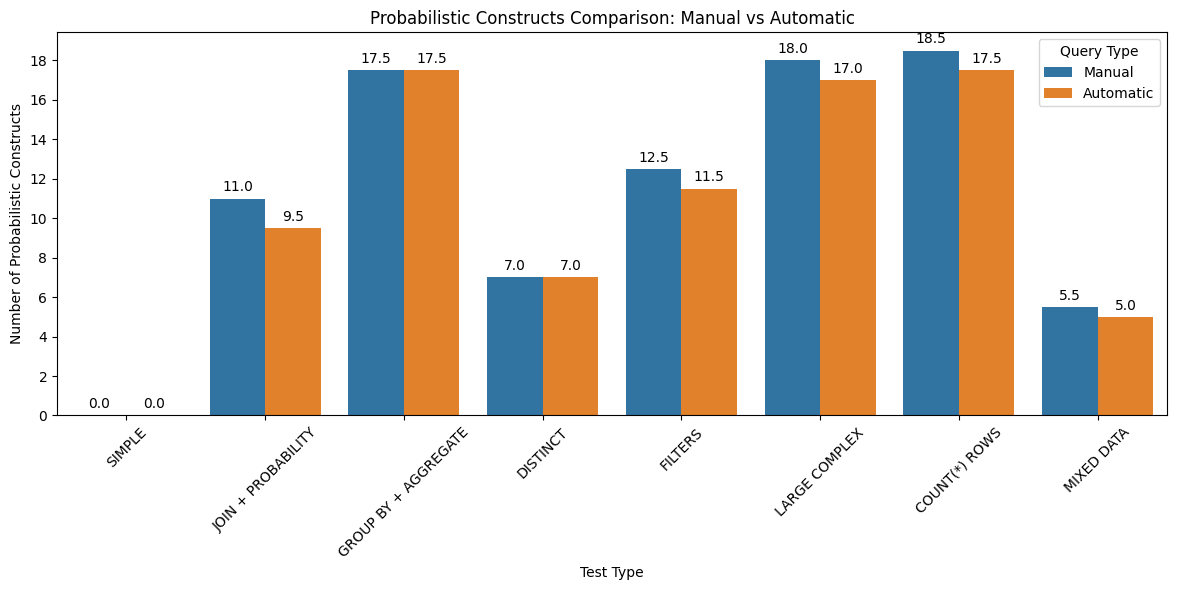

In [12]:
df.columns = [col.strip() for col in df.columns]
df["Test Type"] = df["Test Type"].ffill()

# Get the 2 out of the 3 types of queries - high-level, manual, or auto
# NOTE: the *odd* query types have *even* indexes, and the *even* query types have *odd* indexes!
odd_query = df["Test Query"][0].lower()
even_query = df["Test Query"][1].lower()
odd_query_type = "Manual" if "manual" in odd_query else "Automatic" if "auto" in odd_query else "High-level"
even_query_type = "Manual" if "manual" in even_query else "Automatic" if "auto" in even_query else "High-level"
df["Query Type"] = [
    odd_query_type if i % 2 == 0 else even_query_type
    for i in range(len(df))
]


# Save the diagrams in a folder. Create the directory if it doesn't exist
os.makedirs(f"{odd_query_type}_vs_{even_query_type}_diagrams", exist_ok=True)


# Plot 1: CL comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Test Type", y="Code Lines (CL)", hue="Query Type", errorbar=None)
plt.title(f"Code Lines (CL) Comparison: {odd_query_type} vs {even_query_type}")
plt.ylabel("Code Lines (CL)")
plt.xticks(rotation=45)
plt.legend(title="Query Type")
plt.tight_layout()
plt.savefig(f"{odd_query_type}_vs_{even_query_type}_diagrams/cl_comparison.png", bbox_inches='tight')
plt.show()
plt.close()

# Plot 2: Character Count Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Test Type", y="Characters", hue="Query Type", errorbar=None)
plt.title(f"Character Count Comparison: {odd_query_type} vs {even_query_type}")
plt.ylabel("Character Count")
plt.xticks(rotation=45)
plt.legend(title="Query Type")
plt.tight_layout()
ax = plt.gca()
plt.savefig(f"{odd_query_type}_vs_{even_query_type}_diagrams/character_count_comparison.png")
plt.show()
plt.close()


# Plot 3: Level of Complexity (LoC) Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Test Type", y="Level of Complexity (LoC)", hue="Query Type", errorbar=None)
plt.title(f"Level of Complexity (LoC) Comparison: {odd_query_type} vs {even_query_type}")
plt.ylabel("Level of Complexity (LoC)")
plt.xticks(rotation=45)
plt.legend(title="Query Type")
plt.tight_layout()
plt.savefig(f"{odd_query_type}_vs_{even_query_type}_diagrams/loc_comparison.png")
plt.show()
plt.close()


# Plot 4: Prob Constructs are obvious, but still plot for consistency
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x="Test Type", y="Probabilistic Constructs", hue="Query Type", errorbar=None)
plt.title(f"Probabilistic Constructs Comparison: {odd_query_type} vs {even_query_type}")
plt.ylabel("Number of Probabilistic Constructs")
plt.xticks(rotation=45)
plt.legend(title="Query Type")
plt.tight_layout()

# Set y-axis labels to int safely
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add value labels to the bars since there are some 0 values
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.savefig(f"{odd_query_type}_vs_{even_query_type}_diagrams/probabilistic_constructs_comparison.png")
plt.show()
plt.close()


In [13]:
odd_rows = df[df["Query Type"] == odd_query_type].copy().reset_index(drop=True)
even_rows = df[df["Query Type"] == even_query_type].copy().reset_index(drop=True)

# Construct the comparison DataFrame
comparison_df = pd.DataFrame()
comparison_df["Query Type"] = odd_rows["Test Type"]
comparison_df[f"{odd_query_type} CL"] = odd_rows["Code Lines (CL)"]
comparison_df[f"{even_query_type} CL"] = even_rows["Code Lines (CL)"]
comparison_df[f"{odd_query_type} Characters"] = odd_rows["Characters"]
comparison_df[f"{even_query_type} Characters"] = even_rows["Characters"]
comparison_df[f"{odd_query_type} Complexity"] = odd_rows["Level of Complexity (LoC)"]
comparison_df[f"{even_query_type} Complexity"] = even_rows["Level of Complexity (LoC)"]
comparison_df[f"Probabilistic Constructs ({odd_query_type})"] = odd_rows["Probabilistic Constructs"]
comparison_df[f"Probabilistic Constructs ({even_query_type})"] = even_rows["Probabilistic Constructs"]

# Group by Query Type and aggregate
grouped = comparison_df.groupby("Query Type").agg({
    f"{odd_query_type} CL": "mean",
    f"{even_query_type} CL": "mean",
    f"{odd_query_type} Characters": "mean",
    f"{even_query_type} Characters": "mean",
    f"{odd_query_type} Complexity": "mean",
    f"{even_query_type} Complexity": "mean",
    f"Probabilistic Constructs ({odd_query_type})": "sum",
    f"Probabilistic Constructs ({even_query_type})": "sum"
}).reset_index()

# Compute reductions
grouped["CL Reduction %"] = ((grouped[f"{odd_query_type} CL"] - grouped[f"{even_query_type} CL"]) / grouped[f"{odd_query_type} CL"] * 100).round().astype("Int64").astype(str) + '%'
grouped["Characters Reduction %"] = ((grouped[f"{odd_query_type} Characters"] - grouped[f"{even_query_type} Characters"]) / grouped[f"{odd_query_type} Characters"] * 100).round().astype("Int64").astype(str) + '%'
grouped["Complexity Reduction %"] = ((grouped[f"{odd_query_type} Complexity"] - grouped[f"{even_query_type} Complexity"]) / grouped[f"{odd_query_type} Complexity"] * 100).round().astype("Int64").astype(str) + '%'
grouped["Prob Constructs Reduction #"] = (grouped[f"Probabilistic Constructs ({odd_query_type})"] - grouped[f"Probabilistic Constructs ({even_query_type})"]).round().astype("Int64").astype(str)

# Compute overall reduction as a row
overall_row = {
    "Query Type": "Overall Reduction",
    "CL Reduction %": int(round((grouped[f"{odd_query_type} CL"].sum() - grouped[f"{even_query_type} CL"].sum()) / grouped[f"{odd_query_type} CL"].sum() * 100)),
    "Characters Reduction %": int(round((grouped[f"{odd_query_type} Characters"].sum() - grouped[f"{even_query_type} Characters"].sum()) / grouped[f"{odd_query_type} Characters"].sum() * 100)),
    "Complexity Reduction %": int(round((grouped[f"{odd_query_type} Complexity"].sum() - grouped[f"{even_query_type} Complexity"].sum()) / grouped[f"{odd_query_type} Complexity"].sum() * 100)),
    "Prob Constructs Reduction #": int(round((grouped[f"Probabilistic Constructs ({odd_query_type})"].sum() - grouped[f"Probabilistic Constructs ({even_query_type})"].sum()) / grouped[f"Probabilistic Constructs ({odd_query_type})"].shape[0]))
}
overall_row["CL Reduction %"] = f"{overall_row['CL Reduction %']}%"
overall_row["Characters Reduction %"] = f"{overall_row['Characters Reduction %']}%"
overall_row["Complexity Reduction %"] = f"{overall_row['Complexity Reduction %']}%"
overall_row["Prob Constructs Reduction #"] = str(overall_row["Prob Constructs Reduction #"])

grouped = pd.concat([grouped, pd.DataFrame([overall_row])], ignore_index=True)

# Reorder rows to match the original order
order = [
    "SIMPLE",
    "JOIN + PROBABILITY",
    "GROUP BY + AGGREGATE",
    "DISTINCT",
    "FILTERS",
    "LARGE COMPLEX",
    "COUNT(*) ROWS",
    "MIXED DATA",
    "Overall Reduction"
]
grouped = grouped.set_index("Query Type").reindex(order).reset_index()

grouped_reduction = grouped[[
    "Query Type",
    "CL Reduction %", "Characters Reduction %", "Complexity Reduction %",
    "Prob Constructs Reduction #"
]]

display(grouped_reduction)

,Query Type,CL Reduction %,Characters Reduction %,Complexity Reduction %,Prob Constructs Reduction #
0,SIMPLE,-167%,-115%,-100%,0
1,JOIN + PROBABILITY,-100%,-71%,-80%,3
2,GROUP BY + AGGREGATE,-21%,-24%,-15%,0
3,DISTINCT,-16%,-46%,0%,0
4,FILTERS,-10%,-16%,0%,2
5,LARGE COMPLEX,-9%,-9%,0%,2
6,COUNT(*) ROWS,-8%,-17%,0%,2
7,MIXED DATA,-15%,-25%,0%,1
8,Overall Reduction,-21%,-26%,-12%,1


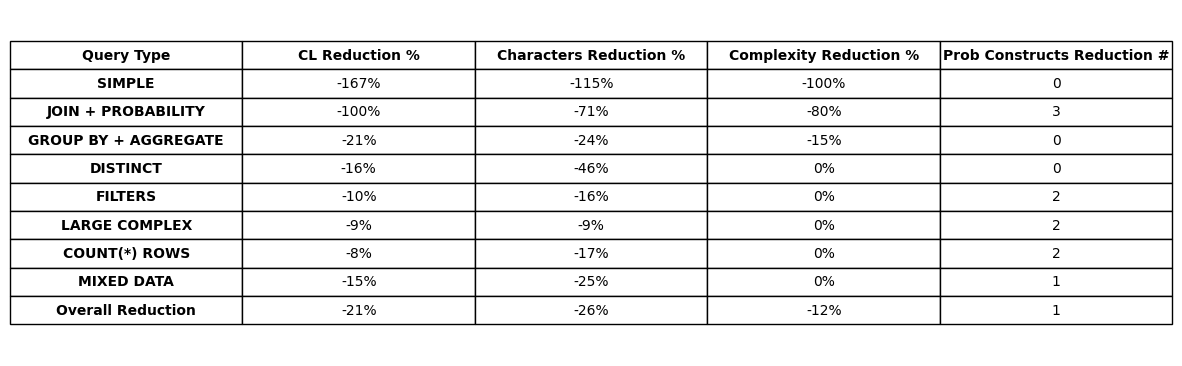

In [14]:
import matplotlib.pyplot as plt

def save_df_as_image(df, filename):
    fig, ax = plt.subplots(figsize=(len(df.columns) * 1.2, len(df) * 0.5))
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(2.5, 1.7)
    # Bold headers
    for (row, col), cell in table.get_celld().items():
        if row == 0 or col == 0:
            cell.set_text_props(weight='bold')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()

save_df_as_image(grouped_reduction, f"{odd_query_type}_vs_{even_query_type}_diagrams/table.png")
